Unknown dog breeds:

['Picardy Sheepdog', 'Dogo Argentino', 'English Pointer', 'Plott Hound', 'Unknown', 'Bedlington Terr', 'Glen Of Imaal', 'Yorkshire', 'Bichon Frise', 'Entlebucher', 'Dutch Shepherd', 'Landseer', 'Wire Hair Fox Terrier', 'Spanish Mastiff', 'Carolina Dog', 'Port Water Dog', 'Jindo', 'American Eskimo', 'Sealyham Terr', 'Treeing Tennesse Brindle', 'Feist', 'American Pit Bull Terrier', 'English Coonhound', 'Patterdale Terr', 'Swiss Hound', 'Treeing Cur', 'Presa Canario', 'Pbgv', 'Bull Terrier Miniature', 'Anatol Shepherd', 'English Shepherd', 'Chinese Crested', 'German Pointer', 'Hovawart', 'Bruss Griffon', 'Alaskan Husky', 'Redbone Hound', 'Germaned Pointer', 'Lowchen', 'West Highland', 'Old English Bulldog', 'Schnauzer Giant', 'Mexican Hairless', 'Bluetick Hound', 'Podengo Pequeno', 'Chesa Bay Retr', 'Softed Wheaten Terrier', 'Hound', 'Cavalier Span', 'Boykin Span']


Dropping NaNs reduced the dataframe by 36 rows.

x_train:
[[ 0.01907681 -0.84753698  0.9709089  -1.143

IndexError: too many indices for array

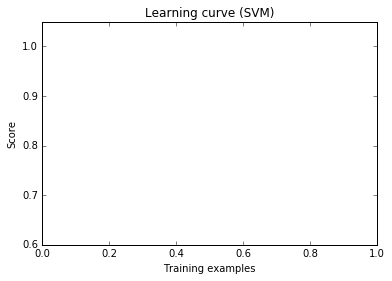

In [13]:
import pandas as pd
import numpy as np
import random
import re
from sklearn import cross_validation, metrics, preprocessing
from sklearn import svm
from sklearn.grid_search import GridSearchCV
from sklearn.learning_curve import learning_curve, validation_curve #temporary
from sklearn.decomposition import PCA
from sklearn.multiclass import OneVsRestClassifier
import matplotlib.pyplot as plt
%matplotlib inline

# ------------------------------------------------------------------
def encode_ordinal(data_col):
    """
    Function encodes categorical data ordinally, accepting a dataframe column
    and returning the encoded dataframe column with a mapping list.
    """
    
    mapping = []
    
    categories = list(set(data_col.values))
    random.shuffle(categories)
    for idx, val in enumerate(categories):
        data_col.loc[data_col == val] = str(idx)
    data_col = data_col.astype(int)
    mapping.append({'mapping': [(x[1], x[0]) for x in list(enumerate(categories))]},)

    return data_col, mapping
# ------------------------------------------------------------------

def breed_to_breed_group(data_col):   
    """
    Function simplifies dog breeds into dog breed categories, yielding more
    examples per category. Accepts a dataframe column of dog breeds and returns
    a dataframe column of dog breeds mapped to categories. Function uses
    data and structure of Andy's Kaggle script, which can be found at: 
    kaggle.com/andraszsom/shelter-animal-outcomes/dog-breeds-dog-groups/comments
    """
    
    # Import Andy's breed groups as dictionary
    fname = './Input/dog_breed_to_category.csv'
    breed_to_category_dict = pd.read_csv(fname, names=['Category'], index_col=0, header=None).to_dict()
    
    unknowns = []
    for idx, element in enumerate(data_col):
        # Simplify breed by removing unnecessary words
        element = element.replace(' Shorthair','')
        element = element.replace(' Medium Hair','')
        element = element.replace(' Longhair','')
        element = element.replace(' Wirehair','')
        element = element.replace(' Rough','')
        element = element.replace(' Smooth Coat','')
        element = element.replace(' Smooth','')
        element = element.replace(' Black/Tan','')
        element = element.replace('Black/Tan ','')
        element = element.replace(' Flat Coat','')
        element = element.replace('Flat Coat ','')
        element = element.replace(' Coat','')

        # If more than one breed, split using '/' separator
        if '/' in element:
            i = 0
            split_element = element.split('/')
            a = ''
            for j in split_element:
                if j[-3:] == 'Mix':
                    if not j[:-4] in breed_to_category_dict['Category'].keys():
                        a += 'Unknown Mix'
                        unknowns.append(j[:-4])
                    else:
                        a += breed_to_category_dict['Category'][j[:-4]]
                else:
                    if not j in breed_to_category_dict['Category'].keys():
                        a += 'Unknown'
                        unknowns.append(j)
                    else:
                        a += breed_to_category_dict['Category'][j]
                a += ' / '
            a = a[:-3]
            data_col.loc[idx] = a
        else:
            if element[-3:] == 'Mix':
                data_col.loc[idx] = element[:-4]
                if not data_col.loc[idx] in breed_to_category_dict['Category'].keys():
                    data_col.loc[idx] = "Unknown Mix"
                    unknowns.append(element[:-4])
            else:
                data_col.loc[idx] = element
                if not data_col.loc[idx] in breed_to_category_dict['Category'].keys():
                    data_col.loc[idx] = "Unknown"
                    unknowns.append(element)
    
    print('Unknown dog breeds: %s\n' % list(set(unknowns)))
    
    breeds = set([val for val in breed_to_category_dict['Category'].keys()])
    # Map breed to category
    for breed in breeds:
        data_col.loc[data_col == breed] = breed_to_category_dict['Category'][breed]        
    return data_col

# ------------------------------------------------------------------
def find_number(string):
    number = re.match('^[0-9]+', string).group(0)
    return int(number)

# ------------------------------------------------------------------
def age_to_months(data_col):
    '''
    Takes list of strings with ages in the regex format ^[0-9]+\b\s+
    and returns a list of integers with the age in months. E.g. 
    '2 years' becomes '24'.
    '''
    
    data_col = data_col.reset_index(drop=True)
    ages = set(data_col)
    for age in ages:
        if age[-3:] == 'day' or age[-4:] == 'days':
            age_number = round(find_number(age) * 12/365)
        elif age[-4:] == 'week' or age[-5:] == 'weeks':
            age_number = round(find_number(age) * 12/52)
        elif age[-5:] == 'month' or age[-6:] == 'months':
            age_number = find_number(age)
        elif age[-4:] == 'year' or age[-5:] == 'years':
            age_number = find_number(age) * 12
        else:
            age_number = -1
            print age_number
        data_col.loc[data_col == age] = int(age_number)

    return data_col

# ------------------------------------------------------------------
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.3, 1.0, 10)):
    """
    Generate a simple plot of the test and traning learning curve. Taken from:
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html.
    Currently fails.
    """
    print train_sizes
    print type(train_sizes)
    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
                estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# ------------------------------------------------------------------
def plot_validation_curve(estimator, X, y, param_range=np.logspace(-9, 3, 9), cv=None):

    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name="estimator__gamma", param_range=param_range,
        cv=cv, scoring="accuracy", n_jobs=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.title("Validation Curve with SVM")
    plt.xlabel("$\gamma$")
    plt.ylabel("Score")
    #plt.ylim(0.0, 1.1)
    plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    plt.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    plt.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    plt.legend(loc="best")
    return plt

# ------------------------------------------------------------------
## Helpfully taken from Eugenia Uchaeva's 'Take a look at the data' script:
## https://www.kaggle.com/uchayder/shelter-animal-outcomes/take-a-look-at-the-data

def get_sex(element):
    """
    Takes string input, searches for sex within string, returns sex
    """
    element = str(element)
    if element.find('Male') >= 0: return 'male'
    if element.find('Female') >= 0: return 'female'
    return 'unknown'

def get_neutered(element):
    """
    Takes string input, searches for neutered status within string, returns 
    status
    """
    element = str(element)
    if element.find('Spayed') >= 0: return 'neutered'
    if element.find('Neutered') >= 0: return 'neutered'
    if element.find('Intact') >= 0: return 'intact'
    return 'unknown'

# ------------------------------------------------------------------
data_raw = pd.read_csv('./input/train.csv')

original_rows = data_raw.shape[0]
data_encoded = data_raw
#print data_encoded.head()

# Split SexuopnOutcome into Sex and NeuteredStatus
data_encoded['Sex'] = data_encoded.SexuponOutcome.apply(get_sex)
data_encoded['NeuteredStatus'] = data_encoded.SexuponOutcome.apply(get_neutered)

# Convert ages into months, being careful to remove NaNs
data_encoded = data_encoded.dropna(subset = ['AgeuponOutcome'])
data_encoded.AgeuponOutcome = age_to_months(data_encoded.AgeuponOutcome)
data_encoded = data_encoded.dropna(subset = ['AgeuponOutcome'])

# Categorise breeds into breed groups
data_encoded.Breed[data_encoded.AnimalType == 'Dog'] = breed_to_breed_group(data_encoded.Breed[data_encoded.AnimalType == 'Dog'])

new_rows = data_encoded.shape[0]
print('Dropping NaNs reduced the dataframe by %i rows.\n' % (original_rows - new_rows))

# Start with ordinal encoding, then try binary encoding and compare
# performance. Ordinal encoding may be acceptable for age.
data_encoded.DateTime = pd.to_datetime(data_encoded.DateTime).dt.month
data_encoded.AnimalType, animaltype_mapping = encode_ordinal(data_encoded.AnimalType)
data_encoded.Sex, sex_mapping = encode_ordinal(data_encoded.Sex)
data_encoded.NeuteredStatus, neuteredstatus_mapping = encode_ordinal(data_encoded.NeuteredStatus)
data_encoded.AgeuponOutcome, ageuponoutcome_mapping = encode_ordinal(data_encoded.AgeuponOutcome)
data_encoded.Breed, breed_mapping = encode_ordinal(data_encoded.Breed)
data_encoded.Color, color_mapping = encode_ordinal(data_encoded.Color)

# Line below would perform one-hot encoding
#df = pd.concat([data_raw, pd.get_dummies(data_raw['Breed']).rename(columns = lambda x: 'Breed_' + str(x))], axis=1)

data_encoded = data_encoded.drop(['Name', 'AnimalID', 'SexuponOutcome'], axis = 1) #Naughtily discarding name for now
data_labels = data_encoded[['OutcomeType', 'OutcomeSubtype']]
data_encoded = data_encoded.drop(data_labels, axis = 1)
#print data_encoded.head()

## Split dataset and train a classifier
x_train, x_test, y_train, y_test = cross_validation.train_test_split(
    data_encoded, data_labels[[0]], test_size = 0.3, random_state = 1)

# Fit scaler on x_train
xy_scaler = preprocessing.StandardScaler()
xy_scaler.fit(x_train)
x_train = xy_scaler.transform(x_train)
print('x_train:\n%s' % x_train[0:5,:])

# Install PCA to reduce dimensions
pca = PCA(0.95) # Return 95% of the variance
x_train = pca.fit(x_train).transform(x_train)
print('PCA - variance retained: %s%%' % sum(pca.explained_variance_ratio_))

# Define SVM - basic, not optimised. Use cross validation / grid search 
# to find optimal hyperparameters
cv = cross_validation.ShuffleSplit(data_encoded.shape[1], n_iter=50,
                                       test_size=0.2, random_state=0)
clf_untuned = OneVsRestClassifier(svm.SVC(kernel='rbf', random_state=0))
params = {
    'estimator__C': [1, 10, 100],
    'estimator__gamma': [0.00001, 0.0001, 0.001],
    'estimator__kernel': ['poly', 'rbf'],
    'estimator__degree':[1, 2, 3],
}
clf_tuned = GridSearchCV(clf_untuned, cv=cv, param_grid=params)
clf_tuned.fit(x_train, y_train)
print('Best parameters: %s' % clf_tuned.best_params_)
print('Best score: %s' % clf_tuned.best_score_)

# Plot learning curve for best params
#title = 'Learning curve (SVM)'
#plot_learning_curve(clf_tuned.best_estimator_, title, x_train, y_train, ylim=(0.6, 1.05), cv=cv)
#plt.show()

# Plot validation curve
plot_validation_curve(clf_tuned.best_estimator_, x_train, y_train, cv=cv)
plt.show()

# Fit scaler, PCA to x_test
x_test = xy_scaler.transform(x_test)
x_test = pca.transform(x_test)

predicted = clf_tuned.predict(x_test)
print("Classification report for classifier %s:\n%s\n"
      % (clf_untuned, metrics.classification_report(y_test, predicted)))
print("Confusion matrix:\n%s" % metrics.confusion_matrix(y_test, predicted))

In [46]:
accuracy = clf_tuned.score(x_test, y_test)
print accuracy

0.610889110889
